In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os

def drop_wave_function(chromosome):
    x = chromosome[0]
    y = chromosome[1]

    return (-(1 + np.cos(12 * np.sqrt(x**2 + y**2))) / (0.5 * (x**2 + y**2) + 2))

def levi_function(chromosome):
    x = chromosome[0]
    y = chromosome[1]

    return  np.sin(3 * np.pi * x) ** 2 + (x - 1) ** 2 * (1 + np.sin(3 * np.pi * y) ** 2) + (y - 1) ** 2 * (1 + np.sin(2 * np.pi * y) ** 2)

In [2]:
# Implementação das diferentes topologias como funções separadas

def topology_global(particles, best_positions, best_fitness):
    """
    Topologia global (gbest) - Todas as partículas se comunicam com todas as outras
    
    Retorna a melhor posição global para cada partícula
    """
    # Encontra o índice da partícula com melhor fitness
    best_idx = np.argmin(best_fitness)
    
    # A melhor posição global é a mesma para todas as partículas
    global_best_position = best_positions[best_idx]
    
    # Retorna a mesma posição para todas as partículas
    return np.tile(global_best_position, (len(particles), 1))


def topology_ring(particles, best_positions, best_fitness, neighborhood_size=2):
    """
    Topologia em anel (lbest) - Cada partícula se comunica apenas com seus vizinhos imediatos
    
    Retorna a melhor posição da vizinhança para cada partícula
    """
    num_particles = len(particles)
    dim = particles.shape[1]
    
    # Inicializa as melhores posições da vizinhança
    neighborhood_best_positions = np.zeros((num_particles, dim))
    
    # Para cada partícula
    for i in range(num_particles):
        # Define os índices dos vizinhos (incluindo a própria partícula)
        neighbors = [i]  # A própria partícula
        
        # Adiciona os vizinhos à esquerda e à direita no anel
        for j in range(1, neighborhood_size + 1):
            neighbors.append((i - j) % num_particles)  # Vizinho à esquerda
            neighbors.append((i + j) % num_particles)  # Vizinho à direita
        
        # Encontra o melhor vizinho
        best_neighbor_idx = neighbors[np.argmin(best_fitness[neighbors])]
        neighborhood_best_positions[i] = best_positions[best_neighbor_idx]
    
    return neighborhood_best_positions

def topology_star(particles, best_positions, best_fitness):
    """
    Topologia em estrela - Uma partícula central se comunica com todas as outras
    """
    num_particles = len(particles)
    dim = particles.shape[1]
    
    # Define a partícula central (usamos a de melhor fitness)
    central_particle_idx = np.argmin(best_fitness)
    
    # Inicializa as melhores posições da vizinhança
    neighborhood_best_positions = np.zeros((num_particles, dim))
    
    # Para cada partícula
    for i in range(num_particles):
        if i == central_particle_idx:
            # A partícula central conhece a melhor global
            best_idx = np.argmin(best_fitness)
            neighborhood_best_positions[i] = best_positions[best_idx]
        else:
            # As outras partículas conhecem apenas a central e a si mesmas
            neighbors = [i, central_particle_idx]
            best_neighbor_idx = neighbors[np.argmin(best_fitness[neighbors])]
            neighborhood_best_positions[i] = best_positions[best_neighbor_idx]
    
    return neighborhood_best_positions


def topology_von_neumann(particles, best_positions, best_fitness):
    """
    Topologia von Neumann - Partículas organizadas em grade 2D, cada uma se 
    comunica com seus 4 vizinhos cardeais
    """
    num_particles = len(particles)
    dim = particles.shape[1]
    
    # Calcula o tamanho da grade (aproximadamente quadrada)
    grid_size = int(np.ceil(np.sqrt(num_particles)))
    
    # Inicializa as melhores posições da vizinhança
    neighborhood_best_positions = np.zeros((num_particles, dim))
    
    # Para cada partícula
    for i in range(num_particles):
        # Calcula posição na grade
        x = i % grid_size
        y = i // grid_size
        
        # Define vizinhos (norte, sul, leste, oeste)
        neighbors = [i]  # A própria partícula
        
        # Norte (y-1, x)
        north = ((y-1) % grid_size) * grid_size + x
        if north < num_particles:
            neighbors.append(north)
        
        # Sul (y+1, x)
        south = ((y+1) % grid_size) * grid_size + x
        if south < num_particles:
            neighbors.append(south)
        
        # Leste (y, x+1)
        east = y * grid_size + ((x+1) % grid_size)
        if east < num_particles:
            neighbors.append(east)
        
        # Oeste (y, x-1)
        west = y * grid_size + ((x-1) % grid_size)
        if west < num_particles:
            neighbors.append(west)
        
        # Encontra o melhor vizinho
        best_neighbor_idx = neighbors[np.argmin(best_fitness[neighbors])]
        neighborhood_best_positions[i] = best_positions[best_neighbor_idx]
    
    return neighborhood_best_positions


In [3]:
def pso(cost_func, topology_func, num_particles, max_iter, dim=2,
        w=0.5, c1=1, c2=2, max_patience=50, **topology_args):
    """
    Algoritmo PSO genérico que recebe uma função de topologia
    
    Parâmetros:
    - cost_func: função a ser otimizada
    - topology_func: função que implementa a topologia de conexão
    - dim: dimensionalidade do problema
    - num_particles: número de partículas
    - max_iter: número máximo de iterações
    - w: coeficiente de inércia
    - c1: coeficiente de aprendizado cognitivo
    - c2: coeficiente de aprendizado social
    - max_patience: máximo de iterações sem melhoria
    - topology_args: argumentos adicionais para a função de topologia
    """
    # Inicializa partículas e velocidades
    particles = np.random.uniform(-5.12, 5.12, (num_particles, dim))
    velocities = np.zeros((num_particles, dim))
    
    # Inicializa melhores posições e valores de fitness
    best_positions = np.copy(particles)
    best_fitness = np.array([cost_func(p) for p in particles])
    
    # Histórico e controle de convergência
    history = []
    patience = 0
    
    # Melhor posição global para análise
    global_best_position = best_positions[np.argmin(best_fitness)]
    global_best_fitness = np.min(best_fitness)
    
    # Nome da topologia para exibição
    topology_name = topology_func.__name__.replace('topology_', '')
    
    # Iteração principal do PSO
    for i in range(max_iter):
        # Determina as melhores posições de acordo com a topologia escolhida
        neighborhood_best_positions = topology_func(particles, best_positions, best_fitness, **topology_args)
        
        # Fatores de aleatoriedade
        r1 = np.random.uniform(0, 1, (num_particles, dim))
        r2 = np.random.uniform(0, 1, (num_particles, dim))
        
        # Atualiza velocidades
        velocities = (w * velocities + 
                     c1 * r1 * (best_positions - particles) + 
                     c2 * r2 * (neighborhood_best_positions - particles))
        
        # Atualiza posições
        particles += velocities
        
        # Avalia fitness de cada partícula
        fitness_values = np.array([cost_func(p) for p in particles])
        
        # Atualiza melhores posições individuais
        improved_indices = np.where(fitness_values < best_fitness)
        best_positions[improved_indices] = particles[improved_indices]
        best_fitness[improved_indices] = fitness_values[improved_indices]
        
        # Verifica se há melhoria global
        current_best_fitness = np.min(fitness_values)
        
        # Atualiza o melhor global para registro
        if current_best_fitness < global_best_fitness:
            global_best_position = particles[np.argmin(fitness_values)]
            global_best_fitness = current_best_fitness
            patience = 0
        else:
            patience += 1
        
        if patience == max_patience:
            break
        
        history.append(global_best_fitness)
        
        if (i+1) % 50 == 0:
            #print(f"Iteration {i+1}: Best fitness = {global_best_fitness}")
            pass
    #print(f"Final best fitness ({topology_name}): {global_best_fitness}")
    return global_best_position, global_best_fitness, history

In [4]:
# Função para comparar as topologias
def compare_topologies(cost_func, topologies, num_particles, max_iter, dim=2,
                      w=0.5, c1=1, c2=2, max_patience=50, runs=5):
    """
    Compara diferentes topologias para o PSO
    
    Parâmetros:
    - cost_func: função de custo a ser minimizada
    - topologies: dicionário com pares {nome_topologia: (função_topologia, args)}
    """
    results = {name: [] for name in topologies}
    
    for run in range(runs):
        #print(f"Executando teste {run+1}/{runs}")
        
        for name, (topology_func, topology_args) in topologies.items():
            # Executa PSO com a topologia atual
            _, _, history = pso(cost_func, topology_func, 
                               dim=dim, num_particles=num_particles,
                               max_iter=max_iter, w=w, c1=c1, c2=c2,
                               max_patience=max_patience, 
                               **topology_args)
            
            # Armazena o histórico
            results[name].append(history)
    
    # Calcula o tamanho máximo dos históricos
    max_len = max([len(h) for histories in results.values() for h in histories])
    # Processa os resultados
    mean_results = {}
    std_dev_history = {}
    median_history = {}
    variance_history = {}

    for name, histories in results.items():
        # Preenche históricos com último valor para ter o mesmo tamanho
        for i in range(len(histories)):
            if len(histories[i]) < max_len:
                histories[i] = np.pad(histories[i], 
                                     (0, max_len - len(histories[i])),
                                     'edge')
        
        # Converte para array numpy
        history_array = np.array(histories)
        
        # Calcula média
        mean_results[name] = np.mean(history_array, axis=0)
        # Calcula desvio padrão
        std_dev_history[name] = np.std(history_array, axis=0)
        # Calcula mediana
        median_history[name] = np.median(history_array, axis=0)
        # Calcula variância
        variance_history[name] = np.var(history_array, axis=0)
    
    return mean_results, std_dev_history, median_history, variance_history
    

In [5]:
def plot_results(mean_results, filename, num_particles, max_iter, runs):
    
    # Plota resultados
    plt.figure(figsize=(10, 6))
    for name, mean_history in mean_results.items():
        plt.plot(mean_history, label=name)

    plt.xlabel('Iterações')
    plt.ylabel('Melhor Fitness')
    plt.legend()
    plt.title('Comparação de Topologias PSO')
    title = 'Comparação de Topologias PSO'
    plt.title(f"{title}\n" + 
          f"n° rodadas = {runs} | n° iterações = {max_iter} | população = {num_particles}",
          fontsize=12)
    plt.grid(True)

    # 💾 Salva em PNG
    # Caminho para o arquivo:
    filepath = os.path.join(
    'graficos//'+filename+'//mean',  # <- nome da pasta (ex: 'graficos_resultados')
    f"part{num_particles}_iter{max_iter}_runs{runs}.png"
    )
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()
    
    # Compara resultados finais
    for name, mean_history in mean_results.items():
        print(f"Fitness médio final ({name}): {mean_history[-1]}")

In [6]:
def plot_std_results(mean_results, std_dev, filename, num_particles, max_iter, runs):
    cmap = plt.get_cmap('tab10')  # Cores categóricas
    topologias = list(mean_results.keys())
    n_graficos = len(topologias)

    n_cols = 2
    n_rows = math.ceil(n_graficos / n_cols)

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows), squeeze=False)
    axes = axes.flatten()  # Facilita o acesso com índice

    for idx, name in enumerate(topologias):
        ax = axes[idx]
        color = cmap(idx % 10)

        mean_history = np.array(mean_results[name])
        std_history = np.array(std_dev[name])

        ax.plot(mean_history, label=name, color=color)
        ax.fill_between(range(len(mean_history)), 
                        mean_history - std_history, 
                        mean_history + std_history, 
                        color=color, alpha=0.2)

        ax.set_title(f'Topologia: {name}\n' + 
          f"n° rodadas = {runs} | n° iterações = {max_iter} | população = {num_particles}", fontsize=12)
        ax.set_xlabel('Iterações')
        ax.set_ylabel('Melhor Fitness')
        ax.grid(True)
        ax.legend()

    # Remove subplots vazios (se houver)
    for i in range(n_graficos, len(axes)):
        fig.delaxes(axes[i])

    # Subtítulo geral
    fig.suptitle(f"n° rodadas = {runs} | n° iterações = {max_iter} | população = {num_particles}", 
                 fontsize=10, y=0.98)

    fig.tight_layout(rect=[0, 0, 1, 0.95])  # Ajusta layout para não sobrepor o subtítulo

    filepath = os.path.join(
    'graficos//'+filename+'//std',  # <- nome da pasta (ex: 'graficos_resultados')
    f"part{num_particles}_iter{max_iter}_runs{runs}.png"
    )
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    plt.show()

In [7]:
def salvar_resultados_em_excel(mean_results, std_dev_history, median_history, variance_history, runs, max_iter, num_particles, filename="resultados.xlsx", passo=20):
    filepath = os.path.join(
    'tabelas//'+filename,  # <- nome da pasta (ex: 'graficos_resultados')
    f"part{num_particles}_iter{max_iter}_runs{runs}.xlsx"
    )
    def criar_dataframe(dicionario, passo):
        dados = {}
        for chave, valores in dicionario.items():
            indices = list(range(0, len(valores), passo))
            if indices[-1] != len(valores) - 1:
                indices.append(len(valores) - 1)
            dados[chave] = [valores[i] for i in indices]
        df = pd.DataFrame.from_dict(dados, orient='index')
        df.columns = [f"iter {i+1}" for i in indices]
        return df

    tabelas = {
        'Media': ('Média dos Resultados', mean_results),
        'Desvio_Padrao': ('Desvio Padrão dos Resultados', std_dev_history),
        'Mediana': ('Mediana dos Resultados', median_history),
        'Variancia': ('Variância dos Resultados', variance_history)
    }

    with pd.ExcelWriter(filepath, engine='xlsxwriter') as writer:
        workbook = writer.book

        # Formatações
        title_format = workbook.add_format({'bold': True, 'font_size': 14, 'align': 'center'})
        subtitle_format = workbook.add_format({'font_size': 10, 'italic': True, 'align': 'center'})
        header_format = workbook.add_format({'bold': True, 'bg_color': '#D9E1F2', 'border': 1, 'align': 'center'})
        gray_row_format = workbook.add_format({'bg_color': '#F2F2F2', 'align': 'center', 'num_format': '0.0000', 'border': 1})
        white_row_format = workbook.add_format({'bg_color': '#FFFFFF', 'align': 'center', 'num_format': '0.0000', 'border': 1})
        algo_format_bold = workbook.add_format({'bold': True, 'align': 'center', 'border': 1, 'bg_color': '#F2F2F2'})
        algo_format_white = workbook.add_format({'bold': True, 'align': 'center', 'border': 1, 'bg_color': '#FFFFFF'})

        for aba, (titulo, dicionario) in tabelas.items():
            df = criar_dataframe(dicionario, passo)
            start_row = 4  # linha 4
            start_col = 1  # coluna B

            df.to_excel(writer, sheet_name=aba, startrow=start_row, startcol=start_col, header=False, index=False)
            worksheet = writer.sheets[aba]

            # Esconde as linhas de grade
            worksheet.hide_gridlines(option=2)

            # Cálculo da letra final da coluna para mesclar título/subtítulo
            last_col_index = start_col + df.shape[1]
            last_col_letter = chr(65 + last_col_index) if last_col_index < 26 else chr(64 + (last_col_index // 26)) + chr(65 + (last_col_index % 26))

            # Título na linha 2
            worksheet.merge_range(f'B2:{last_col_letter}2', titulo, title_format)
            # Subtítulo na linha 3
            worksheet.merge_range(
                f'B3:{last_col_letter}3',
                f"n° rodadas = {str(runs)}  n° iterações = {str(max_iter)}  população = {str(num_particles)}",
                subtitle_format
)


            # Cabeçalhos
            worksheet.write(start_row, start_col, "Algoritmo", header_format)
            for col_num, col_name in enumerate(df.columns, start=1):
                worksheet.write(start_row, start_col + col_num, col_name, header_format)

            # Dados
            for row_num in range(df.shape[0]):
                row_fmt = gray_row_format if row_num % 2 else white_row_format
                algo_fmt = algo_format_bold if row_num % 2 else algo_format_white

                # Nome do algoritmo
                worksheet.write(start_row + 1 + row_num, start_col, df.index[row_num], algo_fmt)

                # Valores
                for col_num in range(df.shape[1]):
                    worksheet.write(start_row + 1 + row_num, start_col + 1 + col_num, df.iloc[row_num, col_num], row_fmt)

            # Largura das colunas
            for col in range(df.shape[1] + 1):
                worksheet.set_column(start_col + col, start_col + col, 15)

In [13]:
if __name__ == "__main__":
    # Define as topologias a serem comparadas
    topologies = {
        'Global': (topology_global, {}),
        'Anel (k=1)': (topology_ring, {'neighborhood_size': 1}),
        'Anel (k=2)': (topology_ring, {'neighborhood_size': 2}),
        'Anel (k=3)': (topology_ring, {'neighborhood_size': 3}),
        'Estrela': (topology_star, {}),
        'Von Neumann': (topology_von_neumann, {})
    }

    num_particles=50
    max_iter=200 
    runs=100
    obj_func='drop_wave'
    
    # Compare as topologias em uma função de benchmark
    mean_history, std_dev_history, median_history, variance_history= compare_topologies(drop_wave_function, topologies, dim=2, num_particles=num_particles, max_iter=max_iter, runs=runs)
    

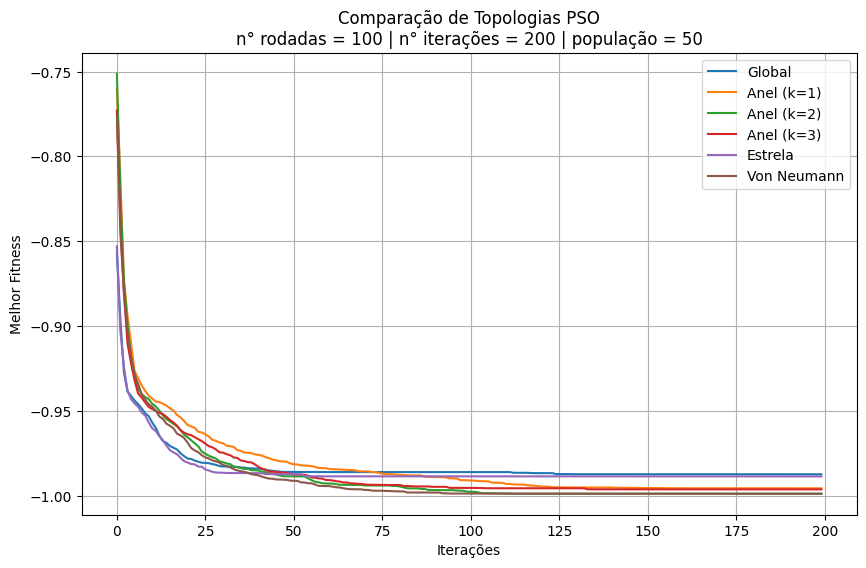

Fitness médio final (Global): -0.987249065561588
Fitness médio final (Anel (k=1)): -0.9955225507087109
Fitness médio final (Anel (k=2)): -0.9987249065561369
Fitness médio final (Anel (k=3)): -0.9961747196683882
Fitness médio final (Estrela): -0.9885241590054291
Fitness médio final (Von Neumann): -0.9987249065561588


In [14]:
plot_results(mean_history, num_particles=num_particles, max_iter=max_iter, runs=runs, filename=obj_func)

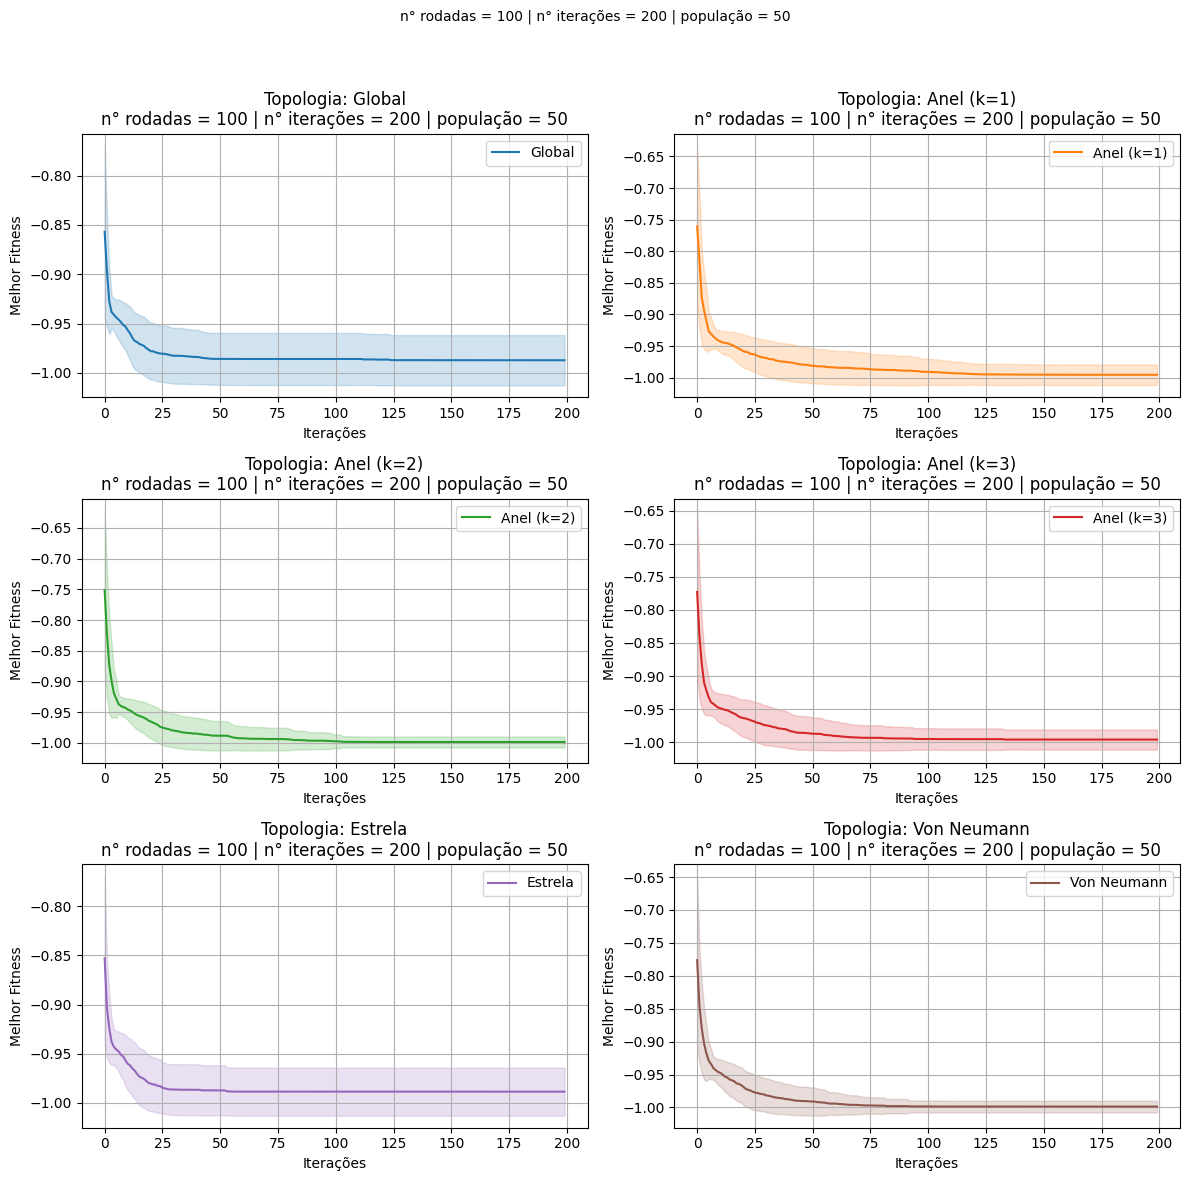

In [15]:
plot_std_results(mean_history, std_dev_history, num_particles=num_particles, max_iter=max_iter, runs=runs, filename=obj_func)

In [16]:
# import numpy as np
# import pandas as pd

# def salvar_resultados_em_excel(mean_results, std_dev_history, median_history, variance_history, arquivo_saida="resultados.xlsx", passo=20):
#     def criar_dataframe(dicionario, passo):
#         dados = {}
#         for chave, valores in dicionario.items():
#             indices = list(range(0, len(valores), passo))
#             if indices[-1] != len(valores) - 1:
#                 indices.append(len(valores) - 1)
#             dados[chave] = [valores[i] for i in indices]
#         df = pd.DataFrame.from_dict(dados, orient='index')
#         df.columns = [f"iter {i+1}" for i in indices]
#         return df

#     tabelas = {
#         'Media': ('Média dos Resultados', mean_results),
#         'Desvio_Padrao': ('Desvio Padrão dos Resultados', std_dev_history),
#         'Mediana': ('Mediana dos Resultados', median_history),
#         'Variancia': ('Variância dos Resultados', variance_history)
#     }

#     with pd.ExcelWriter(arquivo_saida, engine='xlsxwriter') as writer:
#         workbook = writer.book

#         # Estilos
#         title_format = workbook.add_format({'bold': True, 'font_size': 14, 'align': 'center'})
#         header_format = workbook.add_format({'bold': True, 'bg_color': '#D9E1F2', 'border': 1, 'align': 'center'})
#         gray_row_format = workbook.add_format({'bg_color': '#F2F2F2', 'align': 'center', 'num_format': '0.0000', 'border': 1})
#         white_row_format = workbook.add_format({'bg_color': '#FFFFFF', 'align': 'center', 'num_format': '0.0000', 'border': 1})
#         algo_format_bold = workbook.add_format({'bold': True, 'align': 'center', 'border': 1, 'bg_color': '#F2F2F2'})
#         algo_format_white = workbook.add_format({'bold': True, 'align': 'center', 'border': 1, 'bg_color': '#FFFFFF'})

#         for aba, (titulo, dicionario) in tabelas.items():
#             df = criar_dataframe(dicionario, passo)
#             start_row = 3  # linha 4
#             start_col = 1  # coluna B

#             df.to_excel(writer, sheet_name=aba, startrow=start_row, startcol=start_col, header=False, index=False)
#             worksheet = writer.sheets[aba]

#             # ❌ Ocultar linhas de grade
#             worksheet.hide_gridlines(2)  # 2 = oculta linhas horizontais e verticais

#             # Título
#             end_col_letter = chr(66 + df.shape[1])  # 66 = 'B'
#             worksheet.merge_range(f'B2:{end_col_letter}2', titulo, title_format)

#             # Cabeçalho
#             worksheet.write(start_row, start_col, "Algoritmo", header_format)
#             for col_num, col_name in enumerate(df.columns, start=1):
#                 worksheet.write(start_row, start_col + col_num, col_name, header_format)

#             # Dados
#             for row_num in range(df.shape[0]):
#                 row_format = gray_row_format if row_num % 2 else white_row_format
#                 algo_format = algo_format_bold if row_num % 2 else algo_format_white

#                 # Nome do algoritmo
#                 worksheet.write(start_row + 1 + row_num, start_col, df.index[row_num], algo_format)

#                 # Valores
#                 for col_num in range(df.shape[1]):
#                     worksheet.write(start_row + 1 + row_num, start_col + 1 + col_num, df.iloc[row_num, col_num], row_format)

#             # Ajustar largura das colunas
#             for col in range(df.shape[1] + 1):
#                 worksheet.set_column(start_col + col, start_col + col, 15)


In [17]:
salvar_resultados_em_excel(mean_history, std_dev_history, median_history, variance_history, runs=runs, max_iter=max_iter, num_particles=num_particles, filename=obj_func)